In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 闵可夫斯基距离

In [2]:
def mk_dist(v1, v2, p=2, ax=0):
    """
    Minkowski distance
    """
    return (((v1 - v2)**p).sum(axis=ax))**(1/p)

In [3]:
x5 = np.array([0.556, 0.215])
x1 = np.array([0.697, 0.460])

mk_dist(x1, x5)

0.2826764935398767

# 西瓜数据集4.0

In [4]:
watermelon4 = pd.DataFrame({
    "density":[
         0.697, 0.774, 0.634, 0.608, 0.556, 0.403, 0.481, 0.437, 0.666, 0.243,
         0.245, 0.343, 0.639, 0.657, 0.360, 0.593, 0.719, 0.359, 0.339, 0.282,
         0.748, 0.714, 0.483, 0.478, 0.525, 0.751, 0.532, 0.473, 0.725, 0.446
    ],
    "sugar_content": [
         0.460, 0.376, 0.264, 0.318, 0.215, 0.237, 0.149, 0.211, 0.091, 0.267,
         0.057, 0.099, 0.161, 0.198, 0.370, 0.042, 0.103, 0.188, 0.241, 0.257,
         0.232, 0.346, 0.312, 0.437, 0.369, 0.489, 0.472, 0.376, 0.445, 0.459
    ]
})

watermelon4.index = watermelon4.index+1

In [5]:
watermelon4.head()

,density,sugar_content
1,0.697,0.460
2,0.774,0.376
3,0.634,0.264
4,0.608,0.318
5,0.556,0.215


# k-means聚类  
原型聚类

In [6]:
def k_means(df, k):
    """
    TODO!!!:
    df["cluster"] = label_lst
    will change ORIGINAL DataFrame, so need df.copy() as param

    k-means clustering
    df:  pd.DataFrame
    k:   number of clusters

    return:
        cluster labels
    """
    # initial vector mu in ML book
    # df_vector_mu = pd.DataFrame({
    #     "density": [0.403, 0.343, 0.478],
    #     "sugar_content": [0.237, 0.099, 0.437]
    # })

    # initiate vector mu
    df_vector_mu = df.sample(k)
    df_vector_mu.index = range(k)
    # set cluster label for each sample
    label_lst = []
    # TODO !!! optimized by df.apply()
    for idx in range(len(df)):
        xi = df.iloc[idx]
        df_dist = mk_dist(xi, df_vector_mu, ax=1)
        label = df_dist.idxmin()
        label_lst.append(label)
    df["cluster"] = label_lst
    
    # update vector mu
    all_updated = True
    while all_updated:
        update_list = []
        mu_updated = True
        for label in range(k):
            new_mu = df[df["cluster"]==label].iloc[:, :-1].mean()
            # compare pd.Series by s1.equals(s2)
            if df_vector_mu.iloc[label].equals(new_mu):
                mu_updated = False
            else:
                df_vector_mu.iloc[label] = new_mu
                mu_updated = True
            update_list.append(mu_updated)
        
        # check whether all the mu have been updated
        if (sum(update_list) == 0):
            all_updated = False
        else:
            all_updated = True
        
        # update cluster label
        if all_updated:        
            label_lst = []
            for idx in range(len(df)):
                xi = df.iloc[idx, :-1]
                df_dist = mk_dist(xi, df_vector_mu, ax=1)
                label = df_dist.idxmin()
                label_lst.append(label)
            # df["cluster"] = label_lst
    cluster_labels = pd.Series(label_lst, index=df.index)
            
    return cluster_labels

In [7]:
df_kmeans = watermelon4.copy()
cluster_labels = k_means(df_kmeans, 3)
df_kmeans["cluster"] = cluster_labels

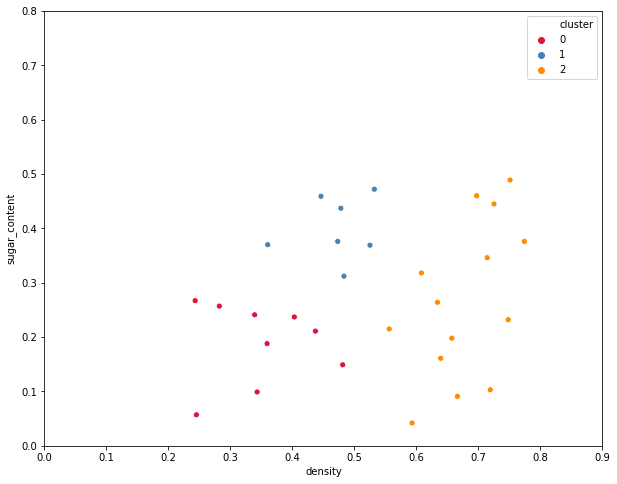

In [8]:
plt.figure(figsize=(10, 8))
colors = {
    0: "#DC143C", 1: "#4682B4", 2:"#FF8C00"
}
sns.scatterplot(x="density", y="sugar_content", hue="cluster", data=df_kmeans, palette=colors, sizes=20)
plt.xlim([0, 0.9])
plt.ylim([0, 0.8])
plt.show()

# 密度聚类

In [9]:
class Queue(object):
    def __init__(self, lst):
        """
        lst: []
        """
        self.items = lst
    
    def status(self):
        return self.items
    
    def is_empty(self):
        empty = True
        if len(self.items) != 0:
            empty = False
        return empty
    
    def en_queue(self, item):
        return self.items.insert(0, item)
        
    def de_queue(self):
        return self.items.pop()
    
    def size(self):
        return len(self.items)


def core_object(df, epsilon=0.11, min_pts=5):
    """
    find core object s.t. epsilon, min_pts
    return:
        core_object's index in df
    """
    core = set()
    for idx in df.index:
        df_dist = mk_dist(df.loc[idx], df, ax=1)
        pts = (df_dist <= epsilon).sum()
        if pts >= min_pts:
            core.add(idx)
    return core


def neighborhood(df, i, epsilon=0.11, min_pts=5):
    """
    find core_object's directly density-reachable, here is called neighbor
    return:
        neighbor's index
    """
    df_dist = mk_dist(df.loc[i], df, ax=1)
    return df[df_dist <= epsilon].index


def dbscan(df, epsilon=0.11, min_pts=5):
    """
    DBSCAN algorithm
    return:
        cluster labels, 0 means NO group
    """
    max_round = 1000
    cluster_dict = {}
    core = core_object(df)

    k = 0
    no_visits = set(df.index)

    while (len(core) != 0) and max_round > 0:
        no_visits_old = no_visits
        c_obj = random.choice(tuple(core))
        queue = Queue([c_obj,])
        # no_visits.discard(c_obj)
        while (not queue.is_empty()):
            q = queue.de_queue()
            neighbor = neighborhood(df, q)
            if len(neighbor) >= min_pts:
                s = set(neighbor)
                delta = s.intersection(no_visits)
                for d in delta:
                    queue.en_queue(d)
                no_visits = no_visits.difference(delta)
        k += 1
        cluster = no_visits_old.difference(no_visits)
        for c in cluster:
            cluster_dict[c] = k
        core = core.difference(cluster)
        max_round -= 1
    
    cluster_labels = pd.Series(
        [cluster_dict.get(idx, 0) for idx in df.index], index=df.index
    )
        
    return cluster_labels


In [10]:
cluster_labels = dbscan(watermelon4)
df_dbscan = watermelon4.copy()
df_dbscan["cluster"] = cluster_labels

In [11]:
cluster_labels.unique()

array([2, 1, 4, 0, 3], dtype=int64)

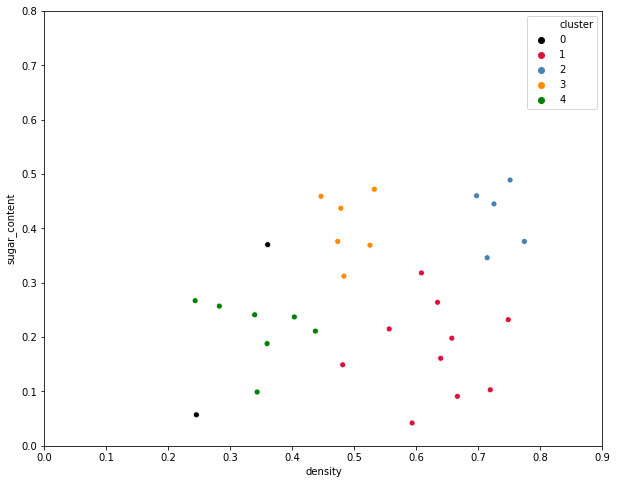

In [12]:
plt.figure(figsize=(10, 8))
colors = {
    1: "#DC143C", 2: "#4682B4", 3: "#FF8C00", 4: "green", 0: "black"
}
sns.scatterplot(x="density", y="sugar_content", hue="cluster", data=df_dbscan, palette=colors, sizes=20)
plt.xlim([0, 0.9])
plt.ylim([0, 0.8])
plt.show()

# 层次聚类

In [15]:
def haus_dist(c1, c2, method="mean"):
    """
    TODO!!!: mask diagonal if c1 and c2 are the same matrix
    method: one of ["mean", "max", "min"]
    """
    # check type of cluster1 and cluster2
    dist_matrix = pd.DataFrame()
    c1_type = type(c1)
    c2_type = type(c2)
    # if isinstance(c1, pd.DataFrame) and isinstance(c2, pd.DataFrame):
    if (c1_type is pd.DataFrame) and (c2_type is pd.DataFrame):
        dist_matrix = c1.apply(lambda x: mk_dist(x, c2, ax=1), axis=1)
    elif (c1_type is pd.Series) and (c2_type is pd.Series):
        dist_matrix = mk_dist(c1, c2, ax=1)
    else:
        dist_matrix = mk_dist(c1, c2, ax=0)

    distance = 0.0
    dist_mat_type = type(dist_matrix)
    if dist_mat_type is float:
        return dist_matrix
    

    if method == "mean":
        distance = (dist_matrix.mean().mean() 
                if dist_mat_type is pd.DataFrame else dist_matrix.mean())
    elif method == "max":
        distance = (dist_matrix.max().max() 
                if dist_mat_type is pd.DataFrame else dist_matrix.max())
    elif method == "min":
        distance = (dist_matrix.min().min() 
                if dist_mat_type is pd.DataFrame else dist_matrix.min())
    else:
        print("method wrong ! [mean|max|min]")
    
    return distance
    
    
def agnes(df, k, haus_dist="mean"):
    """
    AGNES algorithm, bottom-up hierachical clustering
    k: number of clusters
    haus_dist: one of ["mean", "max", "min"]
    """
    cluster_dict = {}
    
    # initiate cluster labels
    cluster_labels = pd.Series(range(1, len(df)+1), index=df.index)
    # initiate distance matrix
    dist_matrix = df.apply(lambda x: mk_dist(x, df, ax=1), axis=1)
    
    m = k
    while m > k:
        # mask diagonal element
        dist_mat_mask = dist_matrix.mask(np.eye(len(dist_matrix), dtype=bool))
        # min_dist_series = dist_mat_mask.idxmin(axis=1)
        # find min value's (row, column) in dist_mat_mask, merge these 2 clusters into 1
        c1_idx, c2_idx = dist_mat_mask.stack().idxmin()
        # update cluster label
        label = cluster_labels[c1_idx]
        cluster_labels[c2_idx] = label
        cluster_dict[label] = set(cluster_labels.index[cluster_labels==label])
        # update dist_matrix
        dist_mat_temp = dist_matrix.drop(index=c2_idx, columns=c2_idx)
        others_mat = dist_matrix.loc[[i for i in df.index if i not in cluster_labels[label]]]
        s = dist_matrix.loc[cluster_dict[label]].apply(lambda x: mk_dist(x, others_mat, ax=1), axis=1).mean()
        s.insert(0, 0.0)
        dist_mat_temp.loc[c1_idx] = s
        dist_m
        
        
        
        
        m -= 1
    

## 距离矩阵dist_matrix  
1. 初始化dist_mat很简单，因为最开始每一个样本是一个簇  
2. 更新dist_mat时，由于不确定要合并的两个簇中的元素个数，所以计算距离会比较麻烦，  
  如果使用

In [41]:
dist_matrix = watermelon4.apply(lambda x: mk_dist(x, watermelon4, ax=1), axis=1)
dist_matrix.head()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
1,0.000000,0.113952,0.205876,0.167586,0.282676,0.369005,0.378652,0.360001,0.370300,0.493320,...,0.233634,0.115261,0.260192,0.220204,0.194589,0.061294,0.165436,0.239232,0.031765,0.251002
2,0.113952,0.000000,0.179287,0.175841,0.271007,0.396184,0.370645,0.375225,0.304777,0.542072,...,0.146328,0.067082,0.297955,0.302220,0.249098,0.115317,0.260346,0.301000,0.084629,0.338339
3,0.205876,0.179287,0.000000,0.059933,0.092114,0.232573,0.191400,0.204005,0.175935,0.391012,...,0.118406,0.114560,0.158446,0.232948,0.151347,0.253602,0.231664,0.196125,0.202588,0.270867
4,0.167586,0.175841,0.059933,0.000000,0.115382,0.220422,0.211400,0.201718,0.234293,0.368546,...,0.164305,0.109636,0.125144,0.176241,0.097417,0.222913,0.171732,0.146932,0.172679,0.214767
5,0.282676,0.271007,0.092114,0.115382,0.000000,0.154574,0.099905,0.119067,0.165759,0.317290,...,0.192751,0.205244,0.121400,0.235304,0.157089,0.336305,0.258118,0.181135,0.285414,0.267649


In [95]:
dist_matrix.iloc[:5, :5]

,1,2,3,4,5
1,0.000000,0.113952,0.205876,0.167586,0.282676
2,0.113952,0.000000,0.179287,0.175841,0.271007
3,0.205876,0.179287,0.000000,0.059933,0.092114
4,0.167586,0.175841,0.059933,0.000000,0.115382
5,0.282676,0.271007,0.092114,0.115382,0.000000


In [105]:
# merge 1, 5 into a cluster
df_1_5 = watermelon4.loc[[1, 5]]
df_2_3_4 = watermelon4.loc[[2, 3, 4]]
df_1_5.apply(lambda x: mk_dist(x, df_2_3_4, ax=1), axis=1)

,2,3,4
1,0.113952,0.205876,0.167586
5,0.271007,0.092114,0.115382


In [104]:
df_2_3_4.apply(lambda x: mk_dist(x, df_1_5, ax=1), axis=1)

,1,5
2,0.113952,0.271007
3,0.205876,0.092114
4,0.167586,0.115382


In [106]:
watermelon4.loc[{1, 3, 5}]

,density,sugar_content
1,0.697,0.460
3,0.634,0.264
5,0.556,0.215


In [112]:
dist_matrix

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
1,0.000000,0.113952,0.205876,0.167586,0.282676,0.369005,0.378652,0.360001,0.370300,0.493320,...,0.233634,0.115261,0.260192,0.220204,0.194589,0.061294,0.165436,0.239232,0.031765,0.251002
2,0.113952,0.000000,0.179287,0.175841,0.271007,0.396184,0.370645,0.375225,0.304777,0.542072,...,0.146328,0.067082,0.297955,0.302220,0.249098,0.115317,0.260346,0.301000,0.084629,0.338339
3,0.205876,0.179287,0.000000,0.059933,0.092114,0.232573,0.191400,0.204005,0.175935,0.391012,...,0.118406,0.114560,0.158446,0.232948,0.151347,0.253602,0.231664,0.196125,0.202588,0.270867
4,0.167586,0.175841,0.059933,0.000000,0.115382,0.220422,0.211400,0.201718,0.234293,0.368546,...,0.164305,0.109636,0.125144,0.176241,0.097417,0.222913,0.171732,0.146932,0.172679,0.214767
5,0.282676,0.271007,0.092114,0.115382,0.000000,0.154574,0.099905,0.119067,0.165759,0.317290,...,0.192751,0.205244,0.121400,0.235304,0.157089,0.336305,0.258118,0.181135,0.285414,0.267649
6,0.369005,0.396184,0.232573,0.220422,0.154574,0.000000,0.117593,0.042802,0.300807,0.162788,...,0.345036,0.329548,0.109659,0.213600,0.179744,0.429660,0.268078,0.155631,0.383338,0.226126
7,0.378652,0.370645,0.191400,0.211400,0.099905,0.117593,0.000000,0.076026,0.193879,0.265646,...,0.279603,0.305120,0.163012,0.288016,0.224357,0.434166,0.327002,0.227141,0.383604,0.311970
8,0.360001,0.375225,0.204005,0.201718,0.119067,0.042802,0.076026,0.000000,0.258536,0.201921,...,0.311708,0.308146,0.110982,0.229689,0.180854,0.419380,0.277752,0.168882,0.371080,0.248163
9,0.370300,0.304777,0.175935,0.234293,0.165759,0.300807,0.193879,0.258536,0.000000,0.458154,...,0.163110,0.259478,0.286932,0.393777,0.311713,0.406975,0.403877,0.344201,0.358883,0.428747
10,0.493320,0.542072,0.391012,0.368546,0.317290,0.162788,0.265646,0.201921,0.458154,0.000000,...,0.506211,0.477579,0.244182,0.290043,0.299880,0.554390,0.354325,0.254521,0.513817,0.279415


In [114]:
mk_dist(watermelon4.iloc[[0,1,2]], watermelon4.iloc[[3,5,6]], ax=1)

1    0.0
2    0.0
3    0.0
4    0.0
6    0.0
7    0.0
dtype: float64

In [73]:
dist_mat_mask = dist_matrix.mask(np.eye(30, dtype=bool))

In [91]:
dist_mat_mask.stack().idxmin()

(1, 29)

In [54]:
mat1 = watermelon4[:4]
mat2 = watermelon4[4:9]

In [117]:
mk_dist(watermelon4.iloc[[0,1,2]], watermelon4.iloc[3])

density          0.190139
sugar_content    0.162616
dtype: float64

In [118]:
mk_dist(watermelon4.iloc[[0,1,2]], watermelon4.iloc[3], ax=1)

1    0.167586
2    0.175841
3    0.059933
dtype: float64

In [121]:
mat = watermelon4.iloc[[0,1,2]]
mat

,density,sugar_content
1,0.697,0.460
2,0.774,0.376
3,0.634,0.264


In [122]:
vec = watermelon4.iloc[3]
vec

density          0.608
sugar_content    0.318
Name: 4, dtype: float64

In [133]:
(((mat - vec)**2).sum(axis=1))**(1/2)

1    0.167586
2    0.175841
3    0.059933
dtype: float64

In [127]:
mk_dist(vec, mat, ax=1)

1    0.167586
2    0.175841
3    0.059933
dtype: float64

In [132]:
(((mat - vec)**2).sum(axis=1))**0.5

1    0.167586
2    0.175841
3    0.059933
dtype: float64

In [135]:
mk_dist(mat, mat)

density          0.0
sugar_content    0.0
dtype: float64

In [136]:
mat2 = watermelon4.iloc[[7, 8]]
mat2

,density,sugar_content
8,0.437,0.211
9,0.666,0.091


In [138]:
mk_dist(mat, mat2)

density          0.0
sugar_content    0.0
dtype: float64

In [156]:
mat.apply(lambda x: mk_dist(x, mat, ax=1), axis=1)

,1,2,3
1,0.000000,0.113952,0.205876
2,0.113952,0.000000,0.179287
3,0.205876,0.179287,0.000000


In [147]:
mat2.apply(lambda x: mk_dist(x, mat, ax=1), axis=1).T

,8,9
1,0.360001,0.370300
2,0.375225,0.304777
3,0.204005,0.175935


In [143]:
mat2

,density,sugar_content
8,0.437,0.211
9,0.666,0.091


In [144]:
mat

,density,sugar_content
1,0.697,0.460
2,0.774,0.376
3,0.634,0.264


In [148]:
mat.dtypes

density          float64
sugar_content    float64
dtype: object

In [154]:
isinstance(mat, pd.DataFrame)

True

In [155]:
isinstance(watermelon4.iloc[0], pd.Series)

True

In [157]:
test = pd.DataFrame() 

In [159]:
test = 9.6

In [160]:
test

9.6

In [174]:
def haus_dist(c1, c2, method="mean"):
    """
    TODO!!!: mask diagonal if c1 and c2 are the same matrix
    method: one of ["mean", "max", "min"]
    """
    # check type of cluster1 and cluster2
    dist_matrix = pd.DataFrame()
    c1_type = type(c1)
    c2_type = type(c2)
    # if isinstance(c1, pd.DataFrame) and isinstance(c2, pd.DataFrame):
    if (c1_type is pd.DataFrame) and (c2_type is pd.DataFrame):
        dist_matrix = c1.apply(lambda x: mk_dist(x, c2, ax=1), axis=1)
    elif (c1_type is pd.Series) and (c2_type is pd.Series):
        dist_matrix = mk_dist(c1, c2, ax=1)
    else:
        dist_matrix = mk_dist(c1, c2, ax=0)

    distance = 0.0
    dist_mat_type = type(dist_matrix)
    if dist_mat_type is float:
        return dist_matrix
    

    if method == "mean":
        distance = (dist_matrix.mean().mean() 
                if dist_mat_type is pd.DataFrame else dist_matrix.mean())
    elif method == "max":
        distance = (dist_matrix.max().max() 
                if dist_mat_type is pd.DataFrame else dist_matrix.max())
    elif method == "min":
        distance = (dist_matrix.min().min() 
                if dist_mat_type is pd.DataFrame else dist_matrix.min())
    else:
        print("method wrong ! [mean|max|min]")
    
    return distance

In [180]:
haus_dist(mat, mat2, method="min")

0.17593464695732902

In [181]:
haus_dist(vec, mat, method="min")

0.1626161123628283

In [177]:
mk_dist(vec, mat, ax=1)

1    0.167586
2    0.175841
3    0.059933
dtype: float64